# `Gen` Experiments
# I. Weighted Coin

(c) David Merrell

In [1]:
using Gen
using PyPlot

## Model

We write a probabilistic program describing the generative process for our entire dataset: $n$ tosses of a coin with probability $p$ of landing "heads".

Our task is to update our beliefs about $p$ -- i.e., infer the posterior distribution of $p$ -- given a dataset of coin-flips.

In [2]:
@gen function coin_tosses(n_tosses)
    
    # Prior: we guess that the coin is probably close to 50-50.
    p = @trace(beta(10.0, 10.0), :prob)
    
    # Do all of the coin flips!
    for i=1:n_tosses
        toss = @trace(bernoulli(p), :z => i)
    end
    
end;

## Data

We'll generate a simulated dataset. Can we recover the `hidden_p`?

In [3]:
hidden_p = 0.61
n_tosses = 100
dataset = [bernoulli(hidden_p) for i=1:n_tosses];

## Exact Prior; Exact Posterior

Before we use Gen to infer the posterior of $p$, we'll first visualize the exact prior and posterior distributions.

This will be a sanity check later, when we use Gen.

In [4]:
p_space = 0.0:0.005:1.0
exact_prior = map(x -> exp(logpdf(beta, x, 10.0, 10.0)), p_space);

For our coin-flip model, the exact posterior is well-known.

We started off with a prior $p \sim \text{Beta}(10,10)$. 
If we do $n$ coin-flips and observe $k$ positives, then we have a posterior $p|X \sim \text{Beta}(10+k, 10+n-k)$.

In [5]:
n_pos = sum(dataset)
n_neg = n_tosses - n_pos
println("number of (heads, tails): (", n_pos, ", ", n_neg, ")")
exact_posterior = map(x -> exp(logpdf(beta, x, 10.0 + n_pos, 10.0 + n_neg)), p_space);

number of (heads, tails): (56, 44)


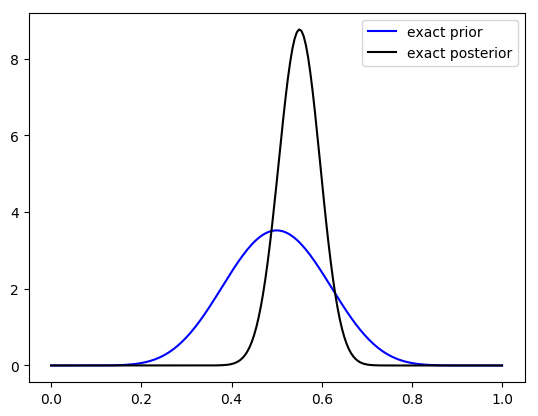

In [6]:
function plot_exact()
    plot(p_space, exact_prior, color="blue", label="exact prior")
    plot(p_space, exact_posterior, color="black", label="exact posterior")
end

plot_exact()
legend()
show()

## Sampling from the posterior: importance resampling

We'll now use Gen to sample from the posterior.

We'll see if the histogram of samples agrees with the _exact_ posterior.

First: we load our data into a `choicemap`. 
This is Gen's way of constraining the model's coin-flips ($z_i$) to match our data.

In [7]:
observations = Gen.choicemap()
for i=1:n_tosses
    observations[:z => i] = dataset[i]
end

Now we write an inference program. This model is very simple, so we'll just use Gen's built-in `importance_resampling` method.

In [8]:
n_posterior_samples = 1000
posterior_samples = zeros(n_posterior_samples) 

for j=1:n_posterior_samples
    tr, _ = Gen.importance_resampling(coin_tosses, (n_tosses,), observations, 40)
    posterior_samples[j] = tr[:prob]
end

Now we'll plot the histogram of posterior samples, in comparison with the exact posterior from earlier.

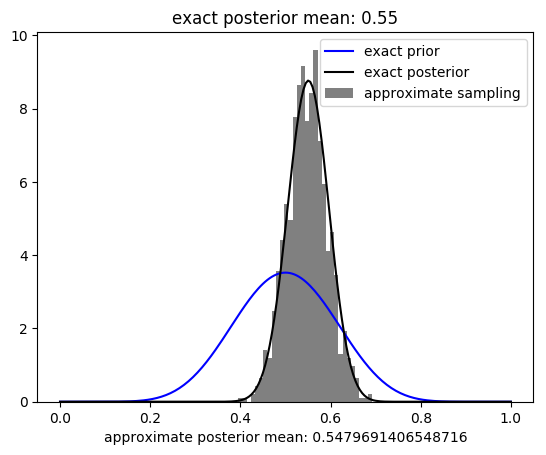

In [9]:
using Statistics


function plot_sample_approx(samples)
    plot_exact()
    hist(samples, color="gray", bins=Int(round(sqrt(n_posterior_samples))), normed=true, label="approximate sampling")
    title("exact posterior mean: $((10.0 + n_pos)/(20.0 + n_tosses))")
    xlabel("approximate posterior mean: $(mean(posterior_samples))")
end

plot_sample_approx(posterior_samples)
legend()
show()

They agree! Fantastic.

## Sampling from the posterior: Metropolis-Hastings MCMC

In complicated models, we'll need to use fancier inference methods than importance resampling.

Metropolis-Hastings is a common choice.

We'll demonstrate Metropolis-Hastings here, in the context of our simple model, before moving on to a more complicated model.

First step: define a proposal distribution. We'll use a narrow beta distribution whose mean coincides with the current value of $p$. This is kind of like using a Gaussian proposal, except that it prevents us from stepping out of $p$'s $[0,1]$ range.

In [10]:
# Define a proposal distribution: 
# we resample from a beta centered at the current value.
@gen function p_proposal(cur_tr)

    strength = 30.0
    @trace(beta(strength*cur_tr[:prob], strength*(1 - cur_tr[:prob])), :prob)

end 

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any], ##p_proposal#372, Bool[0], false)

Now we write an inference program. We'll make calls to Gen's Metropolis-Hastings step implementation (`mh`), but we'll wrap them in loops for burn-in and thinning.

In [11]:
function mh_sample(tr, n_samples=1000, burnin=200, thinning=10)
    
    # for storing the posterior samples
    probs = zeros(n_samples)
    
    # burn-in loop
    for b=1:burnin
        (tr, _) = Gen.mh(tr, p_proposal, ()) 
    end
    
    # thinning loop
    for i=1:n_samples
        for t=1:thinning
            (tr, _) = Gen.mh(tr, p_proposal ,()) 
        end
        
        probs[i] = tr[:prob]
    end
    
    return probs
end

mh_sample (generic function with 4 methods)

Some last things before we begin inference: 
1. we need to build our `choicemap` of observations
2. we need to `generate` the initial program trace.

In [12]:
# Get an initial trace
observations = Gen.choicemap()
for i=1:n_tosses
    observations[:z => i] = dataset[i]
end
(initial_trace, _) = Gen.generate(coin_tosses, (n_tosses,), observations);

Finally: perform MCMC inference!

In [13]:
# Use MCMC to get a posterior sample
p_sample_mh = mh_sample(initial_trace);

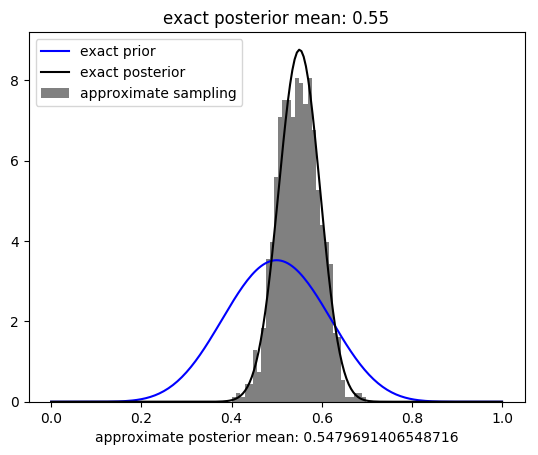

In [14]:
plot_sample_approx(p_sample_mh)
legend()
show()